# Session 5: Gradient Descent 

## House sale-value prediction using the Boston housing dataset

------------------------------------------------------
*ATDST, 2017-2018*

*Pablo M. Olmos olmos@tsc.uc3m.es*

------------------------------------------------------

## Importing Packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn import linear_model

%matplotlib inline

Today, we will continue with the example we used for session 2: Predicting house values using the average number of rooms in the [Boston housing dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names).

Attribute Information can be found [here](https://www.kaggle.com/c/boston-housing).


### Loading Data

We will manage the database using [Panda's library and Dataframes](http://pandas.pydata.org/pandas-docs/stable/tutorials.html)

In [2]:
housing_data=pd.read_csv('./Boston_train.csv')

We divide the whole data set in **80% training** and **20% test**:

In [3]:
N = len(housing_data)

N_train = np.round(0.8 * N).astype(np.int32)

np.random.seed(seed=10) #To fix the random seed

mask = np.random.permutation(len(housing_data))


regression_data_frame = housing_data[['rm','medv']].iloc[list(mask[0:N_train])]

X_0 = np.array(regression_data_frame['rm']) 
Y = np.array(regression_data_frame['medv'])

regression_data_frame_test = housing_data[['rm','medv']].iloc[list(mask[N_train:-1])]

X_0_test = np.array(regression_data_frame_test['rm']) 
Y_test = np.array(regression_data_frame_test['medv'])


# Numerical Optimization with Gradient Descend

As we know, the Ridge regression optimization problem
$$\boldsymbol{\theta}_\lambda = \arg \min_{\theta} \frac{1}{N} \left[\sum_{i=1}^{N} (y^{(i)}-\boldsymbol{\theta}^T\mathbf{x}^{(i)})^2 + \lambda \sum_{j=1}^{D+1} \theta_j^2\right],$$
can be solved using the **normal equation**
$$\boldsymbol{\theta}_\lambda = (\mathbf{X}^T\mathbf{X} + \mathbf{D}_\lambda)^{-1}\mathbf{X}^T\mathbf{y},$$

However, as we advanced in Session 2, computing the normal equation has many important drawbacks:
- You need to keep the full target matrix $\mathbf{X}_{N\times (D+1)}$ in memory, which can be huge in large datasets!
- You need to invert the matrix $(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}$ $\Rightarrow$ $\mathcal{O}(D^3)$ complexity.
- For small data sets ($N\leq D$), $(\mathbf{X}^T\mathbf{X})^{-1}$ can be non-invertible!
- Once you get new data, how do you update $\boldsymbol{\theta}^*$?

Today, we will learn how to apply a very simple algorithm to perform numerical optimization: **gradient descent** (GD). GD is one of the cornerstones of **convex optimization**, but it is also widely used for **non-convex optimization** for instance in [deep learning with neural networks](https://www.youtube.com/watch?v=IHZwWFHWa-w). Be aware that GD is probably the simplest numerical optimization algorithm  and that there is a whole [field](https://web.stanford.edu/group/sisl/k12/optimization/#!index.md) devoted to optimize numerically a function.

In a nutshell, GD tries to iteratively converge to the minimum of a function $f(\boldsymbol{\theta})$ by iteratively applying the following update rule:

$$\boldsymbol{\theta}_{\ell+1} = \boldsymbol{\theta}_\ell - \alpha \nabla f(\boldsymbol{\theta})|_{\boldsymbol{\theta}_\ell},$$

where $\nabla(\cdot)$ is the gradient operator and $\alpha$ is the learning rate. **Setting the learning rate** is a problem in general. Despite we won't cover the topic in detail and just restrict to simple checks, be aware that there are many modifications to GD that attempt to authomatically tune $\alpha$, like the [line search](https://people.maths.ox.ac.uk/hauser/hauser_lecture2.pdf) method.


#### Check out this [beautiful post](http://www.benfrederickson.com/numerical-optimization/)!

___


# Solving the Ridge regression problem using GD

If we define

$$ J(\boldsymbol{\theta}) = \frac{1}{N} \left[\sum_{i=1}^{N} (y^{(i)}-\boldsymbol{\theta}^T\mathbf{x}^{(i)})^2 + \lambda \sum_{j=1}^{D+1}\theta_j^2\right],$$

then it is easy to check that, for $m>0$:

\begin{align}
\frac{\partial J(\boldsymbol{\theta})}{\partial \theta_m}= \frac{2}{N} \left[\lambda\theta_m-\sum_{i=1}^{N} x_m^{(i)}\left(y^{(i)}-\boldsymbol{\theta}^T\mathbf{x}^{(i)}\right)\right]= \frac{2}{N} \left[\lambda\theta_m - \mathbf{e}^T \mathbf{X}_{:,m}\right],
\end{align}
where $\mathbf{e}=\mathbf{y}-\boldsymbol{\theta}^T \mathbf{X}$ is the error vector and $\mathbf{X}_{:,m}$ is the $m$-th column of the normalized training feature matrix. For $m=0$ the first term is not present, since the intercept is not regularized:
\begin{align}
\frac{\partial J(\boldsymbol{\theta})}{\partial \theta_m}= \frac{-2}{N} \left[\sum_{i=1}^{N} x_m^{(i)}\left(y^{(i)}-\boldsymbol{\theta}^T\mathbf{x}^{(i)}\right)\right]= \frac{-2}{N} \left[\mathbf{e}^T \mathbf{X}_{:,m}\right],
\end{align}

Note that in both cases ** the gradient vanishes when the error is zero**.

Lets now program the GD method in a modular way. First, we incorporate some useful functions from the ** previous session**. They will be included as a Python library file.


In [4]:
import Ridge_functions as ridge   # You can find details in provided file S4_Ridge_functions.py

## Compute Gradient

** First ** you have to program a function that computes the gradient and takes as input arguments
- The feature matrix $\mathbf{X}$
- The error vector $\mathbf{e}$
- The value of $\lambda$
- The current value of $\boldsymbol{\theta}$
and returns as output the $(D+1)$-dimensional gradient of $J(\boldsymbol{\theta})$.

In [5]:
def compute_gradient(feature_matrix,error,l,T):
    ## YOUR CODE HERE
    
    gradient = l*T - error @ feature_matrix
    gradient[0] -= l*T[0]
    gradient *= 2.0/feature_matrix.shape[0]
    
    return(gradient)

## Numerical evaluation of the gradient

Before moving forward, let's run a numerical check to verify that the gradient you compute in the function above is correct.

1) Fix a given arbitrary value of $\boldsymbol{\theta}^o$.

2) Introduce a small distortion in one of the components of $\boldsymbol{\theta}$. For instance, $\theta_m^+=\theta^o_m$ for $m\neq 1$ and $\theta^+_1 = \theta^o_1+\epsilon$, where $\epsilon=10^{-3}$. Evaluate the cost function $J(\boldsymbol{\theta}^+)$.

3) Define a new vector $\boldsymbol{\theta}^-$ such that $\theta_m^-=\theta^o_m$ for $m\neq 1$ and $\theta^-_1 = \theta^o_1-\epsilon$, where $\epsilon=10^{-3}$. Evaluate the cost function $J(\boldsymbol{\theta}^-)$.

4) Verify that 

$$\frac{\partial J(\boldsymbol{\theta})}{\partial \theta_1} \approx \frac{J(\boldsymbol{\theta}^+)-J(\boldsymbol{\theta}^-)}{2\epsilon}$$,
where the derivative in the left hand side is given by the second component of the gradient computed using your function above. **Repeat the experiment using the first component of the gradient, i.e., the derivative w.r.t. $\theta_0$**.


In [6]:
# Lets fix a degree
deg = 2
l= 1.0
np.random.seed(seed=10) #To fix the random seed

T = np.random.rand(3)

# This is how we would compute the cost function at T and obtain the normalized train feature matrix
# J_train,_,F_train,_ = ridge.eval_J_Ridge_given_T(X_0,X_0_test,deg,Y,Y_test,l,T)

# Your code here
mod = np.zeros(T.shape)
epsilon = 1e-2
index = 0
mod[index] += epsilon

T_p = T + mod
T_m = T - mod

J_p,_,F_train,_ = ridge.eval_J_Ridge_given_T(X_0,X_0_test,deg,Y,Y_test,l,T_p)
J_m,_,_,_ = ridge.eval_J_Ridge_given_T(X_0,X_0_test,deg,Y,Y_test,l,T_m)

error = (Y - ridge.LS_evaluate(F_train,T))

gradient = compute_gradient(F_train,error,l,T)

print("The gradient at position %d is %f" %(index,gradient[index]))

print("The approximate gradient at position %d is %f" %(index,(J_p-J_m)/(2*epsilon))) # Your code here



The gradient at position 0 is -44.204727
The approximate gradient at position 0 is -44.198928


## Implementing GD

Now, complete the following function to estimate the Ridge solution using gradient descend. The inputs are:

- The normalized train feature matrix $\mathbf{X}$
- The target vector $\mathbf{Y}$
- The initial value of theta $\boldsymbol{\theta}$
- The step size $\alpha$
- The stopping tolerance: a threshold that halts the algorithm when the norm of the gradient is below this limit
- The maximum number of iterations

In [7]:
def regression_gradient_descent(F_train, Y, T_0, l, step_size, tolerance, iter_max,verbose=True,period_verbose=1000):
    converged = False 
    T = np.array(T_0) # make sure it's a numpy array
    it=0
    
    while not converged:

        # First, compute the error vector 
        error= (Y - ridge.LS_evaluate(F_train,T)) #YOUR CODE HERE
        
        # Second compute the gradient vector
        gradient= compute_gradient(F_train,error,l,T) #YOUR CODE HERE
        
        # Finally, update the theta vector
        T=T- step_size * gradient #YOUR CODE HERE
        
        grad_norm=np.linalg.norm(gradient)
        
        if(verbose==True and it % period_verbose ==0):
            J_Ridge = ridge.J_error_L2(Y,ridge.LS_evaluate(F_train,T),T,l)  
            print ("Iterations = %d" %(it))
            print ("Gradient norm %f" %(grad_norm))
            print ("Ridge cost function %f" %(J_Ridge))            

        if grad_norm < tolerance:
            converged = True
        elif it > iter_max:
            converged = True
        else:
            it=it+1
        
    if(converged==True):
        J_Ridge = ridge.J_error_L2(Y,ridge.LS_evaluate(F_train,T),T,l)  
        print ("Iterations = %d" %(it))
        print ("Gradient norm %f" %(grad_norm))
        print ("Ridge cost function %f" %(J_Ridge))
        
    return(T)

## Evaluate solution and compare with normal equation

Run an example to verify that the GD solution is close to the one predicted by the normal equation. Investigate the effect of the step size.

Iterations = 0
Gradient norm 52.078218
Ridge cost function 549.710059
Iterations = 10000
Gradient norm 0.033605
Ridge cost function 33.629585
Iterations = 20000
Gradient norm 0.013750
Ridge cost function 33.576988
Iterations = 20001
Gradient norm 0.013748
Ridge cost function 33.576986


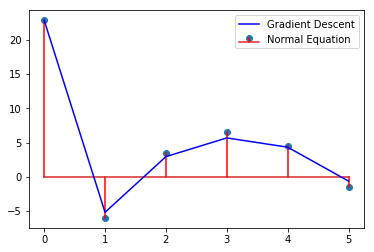

In [13]:
# Lets fix a degree
deg = 5
l= 1.0
T = np.random.rand(6)

#Cost function at initial T and feature matrix
J_0,_,F_train,_ = ridge.eval_J_Ridge_given_T(X_0,X_0_test,deg,Y,Y_test,l,T)

step_size = 1e-02
iter_max = 2e4
tolerance = 1e-03
period= 1e04

T_opt = regression_gradient_descent(F_train, Y, T, l, step_size, tolerance, iter_max,verbose=True,period_verbose=period)

T_normal = ridge.Ridge_solution(F_train,Y,l)

plt.stem(T_normal,'r',label='Normal Equation')
plt.plot(T_opt,'b',label='Gradient Descent')
plt.legend()